In [1]:
import requests
import json
import os

# Function to fetch data for all pages
def get_data_from_api(url):
    results = []
    while url:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            results.extend(data['results'])
            print(f'Sucessfully extracted page: {url}')
            url = data['next'] if 'next' in data else None
        else:
            print(f"Failed to retrieve data from {url}")
            break
    return results

# Function to save data as JSON
def save_as_json(data, filename):
    os.makedirs('data', exist_ok=True)
    with open(os.path.join('data', filename), 'w') as f:
        json.dump(data, f, indent=4)


In [2]:
dfs = ['people', 'films', 'vehicles']

for df in dfs:
    globals()[df+'_data'] = get_data_from_api(f'https://swapi.dev/api/{df}/')
    save_as_json(globals()[df+'_data'], f'star_wars_api_data_{df}.json')


Sucessfully extracted page: https://swapi.dev/api/people/
Sucessfully extracted page: https://swapi.dev/api/people/?page=2
Sucessfully extracted page: https://swapi.dev/api/people/?page=3
Sucessfully extracted page: https://swapi.dev/api/people/?page=4
Sucessfully extracted page: https://swapi.dev/api/people/?page=5
Sucessfully extracted page: https://swapi.dev/api/people/?page=6
Sucessfully extracted page: https://swapi.dev/api/people/?page=7
Sucessfully extracted page: https://swapi.dev/api/people/?page=8
Sucessfully extracted page: https://swapi.dev/api/people/?page=9
Sucessfully extracted page: https://swapi.dev/api/films/
Sucessfully extracted page: https://swapi.dev/api/vehicles/
Sucessfully extracted page: https://swapi.dev/api/vehicles/?page=2
Sucessfully extracted page: https://swapi.dev/api/vehicles/?page=3
Sucessfully extracted page: https://swapi.dev/api/vehicles/?page=4


In [4]:
import numpy as np
import pandas as pd
import sqlite3

## EXTRACT

In [5]:
dfs = ['people', 'films', 'vehicles']

# Load data into DataFrames
for df in dfs:
   globals()['df_'+df+'_extracted'] = pd.read_json(f'data/star_wars_api_data_{df}.json')
   print(f"The table df_{df}_extracted is created.")

print("JSON files loaded successfully.")

The table df_people_extracted is created.
The table df_films_extracted is created.
The table df_vehicles_extracted is created.
JSON files loaded successfully.


## TRANSFORM

**--> cleaning** of df_people_extracted:
1. I deleted columns: *mass, birth_year, species*, because of many n/a values 
2. In columns *hair_color, skin_color, eye_color* I replaced ',' with '_'
3. In column *hair*, I replaced 'none' with 'non_hair'
3. I repleced all nons with NaN value.
4. To create **unique ID** for each of the person in the df_people_cleand I used last numer from the URL code.


In [6]:
df_people_cleaned = df_people_extracted[[
    'name',
    'height',
    'hair_color', 
    'skin_color', 
    'eye_color',
    'gender',
    'homeworld', 
    'films',  
    'vehicles',
    'starships', 
    'created', 
    'edited', 
    'url'
]].rename(
    columns={
    'url': 'person_url',
    'homeworld': 'planet' 
    }  
)

df_people_cleaned['hair_color'] = df_people_cleaned['hair_color'].str.replace(', ', '-')
df_people_cleaned['skin_color'] = df_people_cleaned['skin_color'].str.replace(', ', '-')
df_people_cleaned['eye_color'] = df_people_cleaned['eye_color'].str.replace(', ', '-')

df_people_cleaned['hair_color'] = df_people_cleaned['hair_color'].str.replace('none', "non_hair")
df_people_cleaned['gender'] = df_people_cleaned['gender'].str.replace('n/a', "machine")


for column in ['name','height', 'hair_color', 'skin_color', 'eye_color', 'created', 'edited']:
    df_people_cleaned[column] = df_people_cleaned[column].replace('n/a', np.nan)
    df_people_cleaned[column] = df_people_cleaned[column].replace('unknown', np.nan)

df_people_cleaned['person_id'] = df_people_cleaned['person_url'] .apply(lambda url: url.split('/')[-2]) #created unique ID from URL

df_people_cleaned.head()

,name,height,hair_color,skin_color,eye_color,gender,planet,films,vehicles,starships,created,edited,person_url,person_id
0,Luke Skywalker,172,blond,fair,blue,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...","[https://swapi.dev/api/vehicles/14/, https://s...","[https://swapi.dev/api/starships/12/, https://...",2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/,1
1,C-3PO,167,NaN,gold,yellow,machine,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[],[],2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/,2
2,R2-D2,96,NaN,white-blue,red,machine,https://swapi.dev/api/planets/8/,"[https://swapi.dev/api/films/1/, https://swapi...",[],[],2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/,3
3,Darth Vader,202,non_hair,white,yellow,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[],[https://swapi.dev/api/starships/13/],2014-12-10T15:18:20.704000Z,2014-12-20T21:17:50.313000Z,https://swapi.dev/api/people/4/,4
4,Leia Organa,150,brown,light,brown,female,https://swapi.dev/api/planets/2/,"[https://swapi.dev/api/films/1/, https://swapi...",[https://swapi.dev/api/vehicles/30/],[],2014-12-10T15:20:09.791000Z,2014-12-20T21:17:50.315000Z,https://swapi.dev/api/people/5/,5


In the **df_people_cleaned**, there are lists of **vehicles, starships, and films**, which are part of a Many-to-Many relations. To make them easier to read in SQL, I represented these relationships in new tables N-N.
I checked and data is complementary, so I dont need to complete the relations tables.

Also, to clean the table I changed all URL codes with the ID. I created a 1-N tables to connect URL with Id.

In [7]:
#function to create N-N tables
def create_table_for_many_to_many(initial_df, column_id, column_with_list):
    df = initial_df[[column_id, column_with_list]].explode(column_with_list)
    df.dropna(how = 'any', inplace=True)
    df[f'{column_with_list}_id'] = df[column_with_list].apply(lambda url: url.split('/')[-2])
    df = df.drop(columns=column_with_list)
    return df

#function to create 1-N tables
def create_table_for_one_to_many(df, column_id, column_with_url, title_column_id, title_column_url):
    data = []
    for _, row in df.iterrows():
        data.append({title_column_id: row[column_id], title_column_url: row[column_with_url] })
    return pd.DataFrame(data).drop_duplicates().sort_values(column_id).reset_index(drop=True).dropna()


In [8]:
#Table for PEOPLE - VEHICLES N-N relation
df_people_vehicle = create_table_for_many_to_many(df_people_cleaned, 'person_id', 'vehicles')

#Table for PEOPLE - FILMS N-N relation
df_person_film = create_table_for_many_to_many(df_people_cleaned, 'person_id', 'films')

#Table for PEOPLE - STARSHIPS N-N relation
df_person_starship = create_table_for_many_to_many(df_people_cleaned, 'person_id', 'starships')

df_people_vehicle.head()

,person_id,vehicles_id
0,1,14
0,1,30
4,5,30
9,10,38
10,11,44


I created *planet_id* and 1-N table to connect ids with URL codes.

In [9]:
#create ID column for species and planet
df_people_cleaned['planet_id'] = df_people_cleaned['planet'].apply(lambda url: url.split('/')[-2] if url is not None else None)

##one to many tables
df_planet = create_table_for_one_to_many(df_people_cleaned, 'planet_id', 'planet', 'planet_id', 'planet_url')

df_planet.head()

,planet_id,planet_url
0,1,https://swapi.dev/api/planets/1/
1,10,https://swapi.dev/api/planets/10/
2,11,https://swapi.dev/api/planets/11/
3,12,https://swapi.dev/api/planets/12/
4,14,https://swapi.dev/api/planets/14/


In [10]:
#drop columns I don't need
df_people_cleaned = df_people_cleaned.drop(columns={'starships', 'vehicles', 'films', 'planet'})
df_people_cleaned.head()

,name,height,hair_color,skin_color,eye_color,gender,created,edited,person_url,person_id,planet_id
0,Luke Skywalker,172,blond,fair,blue,male,2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/,1,1
1,C-3PO,167,NaN,gold,yellow,machine,2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/,2,1
2,R2-D2,96,NaN,white-blue,red,machine,2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/,3,8
3,Darth Vader,202,non_hair,white,yellow,male,2014-12-10T15:18:20.704000Z,2014-12-20T21:17:50.313000Z,https://swapi.dev/api/people/4/,4,1
4,Leia Organa,150,brown,light,brown,female,2014-12-10T15:20:09.791000Z,2014-12-20T21:17:50.315000Z,https://swapi.dev/api/people/5/,5,2


**--> cleaning** of df_vehicles_extracted:
1. I deleted columns: *consumables, pilots* because of many n/a values and column *name* bacause it is simillar to *name*
2. In columns *cargo_capacity* I replaced 'none' with '0'
3. I repleced all nons with NaN value.
4. I created column of *all_people_on_board* that sum *crew* and *passangers*
5. To create **unique ID** for each of the vehicles I used last numer from the URL code.
6. I cleaned the **vehicle_class* column

In [11]:
df_vehicles_cleaned = df_vehicles_extracted[[
    'name',
    'manufacturer',
    'length', 
    'max_atmosphering_speed', 
    'crew',
    'passengers', 
    'cargo_capacity',
    'vehicle_class',
    'films',
    'created',
    'edited',
    'url'
]].rename(columns=
          {
              'url': 'vehicle_url'
          })


df_vehicles_cleaned['cargo_capacity'] = df_vehicles_cleaned['cargo_capacity'].str.replace('none', '0')
df_vehicles_cleaned['passengers'] = df_vehicles_cleaned['passengers'].replace('unknown', 0)
df_vehicles_cleaned['passengers'] = df_vehicles_cleaned['passengers'].astype(int) #changing the type to int
df_vehicles_cleaned['all_people_on_board'] = df_vehicles_cleaned['crew'] + df_vehicles_cleaned['passengers'] #creating 'all_people_on_board'

df_vehicles_cleaned['vehicle_class'] = df_vehicles_cleaned['vehicle_class'].str.replace('air speeder', 'airspeeder')

for column in ['cargo_capacity', 'length', 'max_atmosphering_speed']:
    df_vehicles_cleaned[column] = df_vehicles_cleaned[column].replace('unknown', np.nan)

df_vehicles_cleaned['vehicle_id'] = df_vehicles_cleaned['vehicle_url'].apply(lambda url: url.split('/')[-2])
df_vehicles_cleaned.head()

,name,manufacturer,length,max_atmosphering_speed,crew,passengers,cargo_capacity,vehicle_class,films,created,edited,vehicle_url,all_people_on_board,vehicle_id
0,Sand Crawler,Corellia Mining Corporation,36.8,30,46,30,50000,wheeled,"[https://swapi.dev/api/films/1/, https://swapi...",2014-12-10T15:36:25.724000Z,2014-12-20T21:30:21.661000Z,https://swapi.dev/api/vehicles/4/,76,4
1,T-16 skyhopper,Incom Corporation,10.4,1200,1,1,50,repulsorcraft,[https://swapi.dev/api/films/1/],2014-12-10T16:01:52.434000Z,2014-12-20T21:30:21.665000Z,https://swapi.dev/api/vehicles/6/,2,6
2,X-34 landspeeder,SoroSuub Corporation,3.4,250,1,1,5,repulsorcraft,[https://swapi.dev/api/films/1/],2014-12-10T16:13:52.586000Z,2014-12-20T21:30:21.668000Z,https://swapi.dev/api/vehicles/7/,2,7
3,TIE/LN starfighter,Sienar Fleet Systems,6.4,1200,1,0,65,starfighter,"[https://swapi.dev/api/films/1/, https://swapi...",2014-12-10T16:33:52.860000Z,2014-12-20T21:30:21.670000Z,https://swapi.dev/api/vehicles/8/,1,8
4,Snowspeeder,Incom corporation,4.5,650,2,0,10,airspeeder,[https://swapi.dev/api/films/2/],2014-12-15T12:22:12Z,2014-12-20T21:30:21.672000Z,https://swapi.dev/api/vehicles/14/,2,14


I created table Many to Many for vehicles and films.

In [12]:
#Table for VEHICLES - FILMS N-N relation
df_vehicle_film = create_table_for_many_to_many(df_vehicles_cleaned, 'vehicle_id', 'films')
df_vehicle_film.head()


,vehicle_id,films_id
0,4,1
0,4,5
1,6,1
2,7,1
3,8,1


In [13]:
#cleaning
df_vehicles_cleaned = df_vehicles_cleaned.drop(columns= "films")

**--> cleaning** of df_films_extracted:
1. I deleted columns: *opening_crawl, characters, planets, starships, vehicles, species,* 
2. To create **unique ID** for each of the films, I used last numer from the URL code.
3. I added get.dummies to split *producers of the films*.

In [14]:
df_films_cleaned = df_films_extracted[[
    'title',
    'episode_id',
    'director',
    'producer',
    'release_date', 
    'created',
    'edited', 
    'url',
]].rename(
    columns={ 
        'url': 'film_url',
     }
)

df_films_cleaned['film_id'] = df_films_cleaned['film_url'].apply(lambda url: url.split('/')[-2])

df_films_cleaned

,title,episode_id,director,producer,release_date,created,edited,film_url,film_id
0,A New Hope,4,George Lucas,"Gary Kurtz, Rick McCallum",1977-05-25,2014-12-10T14:23:31.880000Z,2014-12-20T19:49:45.256000Z,https://swapi.dev/api/films/1/,1
1,The Empire Strikes Back,5,Irvin Kershner,"Gary Kurtz, Rick McCallum",1980-05-17,2014-12-12T11:26:24.656000Z,2014-12-15T13:07:53.386000Z,https://swapi.dev/api/films/2/,2
2,Return of the Jedi,6,Richard Marquand,"Howard G. Kazanjian, George Lucas, Rick McCallum",1983-05-25,2014-12-18T10:39:33.255000Z,2014-12-20T09:48:37.462000Z,https://swapi.dev/api/films/3/,3
3,The Phantom Menace,1,George Lucas,Rick McCallum,1999-05-19,2014-12-19T16:52:55.740000Z,2014-12-20T10:54:07.216000Z,https://swapi.dev/api/films/4/,4
4,Attack of the Clones,2,George Lucas,Rick McCallum,2002-05-16,2014-12-20T10:57:57.886000Z,2014-12-20T20:18:48.516000Z,https://swapi.dev/api/films/5/,5
5,Revenge of the Sith,3,George Lucas,Rick McCallum,2005-05-19,2014-12-20T18:49:38.403000Z,2014-12-20T20:47:52.073000Z,https://swapi.dev/api/films/6/,6


In [15]:
# Create dummies for producers
producer_names = ['George Lucas', 'Gary Kurtz', 'Howard G. Kazanjian', 'Rick McCallum']

df_producers = pd.DataFrame(df_films_cleaned.loc[:, ['film_id', 'producer']])
df_producers[producer_names] = 0

# Iterate through the rows and set 1 for each producer
for index, row in df_producers.iterrows():
    producers = row['producer'].split(', ')
    for producer in producer_names:
        if producer in producers:
            df_producers.at[index, producer] = 1

df_producers = df_producers[[
    'George Lucas',
    'Gary Kurtz',
    'Howard G. Kazanjian',
    'Rick McCallum'
]].rename(
    columns={
        'George Lucas': 'producer_George_Lucas',
        'Gary Kurtz': 'producer_Gary_Kurtz',
        'Howard G. Kazanjian': 'producer_Howard_G_Kazanjian',
        'Rick McCallum': 'producer_Rick_McCallum'
     }
)

# Merging tables
df_films_cleaned = pd.concat([df_films_cleaned, df_producers], axis=1)

# df_producers.head()
df_films_cleaned


,title,episode_id,director,producer,release_date,created,edited,film_url,film_id,producer_George_Lucas,producer_Gary_Kurtz,producer_Howard_G_Kazanjian,producer_Rick_McCallum
0,A New Hope,4,George Lucas,"Gary Kurtz, Rick McCallum",1977-05-25,2014-12-10T14:23:31.880000Z,2014-12-20T19:49:45.256000Z,https://swapi.dev/api/films/1/,1,0,1,0,1
1,The Empire Strikes Back,5,Irvin Kershner,"Gary Kurtz, Rick McCallum",1980-05-17,2014-12-12T11:26:24.656000Z,2014-12-15T13:07:53.386000Z,https://swapi.dev/api/films/2/,2,0,1,0,1
2,Return of the Jedi,6,Richard Marquand,"Howard G. Kazanjian, George Lucas, Rick McCallum",1983-05-25,2014-12-18T10:39:33.255000Z,2014-12-20T09:48:37.462000Z,https://swapi.dev/api/films/3/,3,1,0,1,1
3,The Phantom Menace,1,George Lucas,Rick McCallum,1999-05-19,2014-12-19T16:52:55.740000Z,2014-12-20T10:54:07.216000Z,https://swapi.dev/api/films/4/,4,0,0,0,1
4,Attack of the Clones,2,George Lucas,Rick McCallum,2002-05-16,2014-12-20T10:57:57.886000Z,2014-12-20T20:18:48.516000Z,https://swapi.dev/api/films/5/,5,0,0,0,1
5,Revenge of the Sith,3,George Lucas,Rick McCallum,2005-05-19,2014-12-20T18:49:38.403000Z,2014-12-20T20:47:52.073000Z,https://swapi.dev/api/films/6/,6,0,0,0,1


## Load

In [16]:
conn = sqlite3.connect('data/starwars.db')
c = conn.cursor()

c.execute(f"CREATE TABLE IF NOT EXISTS people ({', '.join(df_people_cleaned.columns)})")
conn.commit()
df_people_cleaned.to_sql('people', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS vehicles ({', '.join(df_vehicles_cleaned.columns)})")
conn.commit()
df_vehicles_cleaned.to_sql('vehicles', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS films ({', '.join(df_films_cleaned.columns)})")
conn.commit()
df_films_cleaned.to_sql('films', conn, if_exists='replace', index = False)

#
c.execute(f"CREATE TABLE IF NOT EXISTS person_vehicle ({', '.join(df_people_vehicle.columns)})")
conn.commit()
df_people_vehicle.to_sql('person_vehicle', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS person_film ({', '.join(df_person_film.columns)})")
conn.commit()
df_person_film.to_sql('person_film', conn, if_exists='replace', index = False)

c.execute(f"CREATE TABLE IF NOT EXISTS vehicle_film ({', '.join(df_vehicle_film.columns)})")
conn.commit()
df_vehicle_film.to_sql('vehicle_film', conn, if_exists='replace', index = False)

#
c.execute(f"CREATE TABLE IF NOT EXISTS planet ({', '.join(df_planet.columns)})")
conn.commit()
df_planet.to_sql('planet', conn, if_exists='replace', index = False)

## numbers - vehicles.length


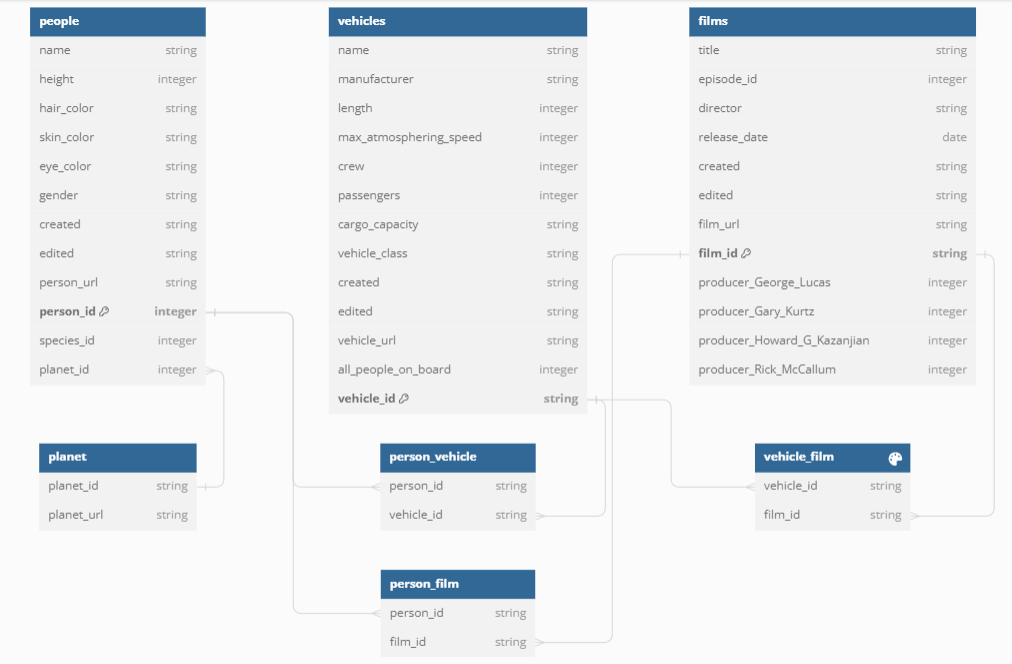

In [17]:
con = sqlite3.connect('data/starwars.db')

## Exercises
Do some SQL analysis
- 1 request with **INNER**

Show what are the most capacious vehicles (in terms of people on board) in each of the movies and introduce their manufacturers, arrange by vehicle capacity.

Comment: here I chose INNER because I need all vehicles that were used in the movies (the truth is that all were used in the movies (the dataset is from the movies), but here I am sure that I am using correct group of vehicles).

In [18]:
pd.read_sql('''
    WITH size_rank AS (
        SELECT 
            f.title AS film_title,
            f.film_id,
            v.name AS vehicle_name,
            v.all_people_on_board AS number_of_people_on_board,        
            ROW_NUMBER() OVER (PARTITION BY f.title ORDER BY (v.all_people_on_board) DESC, f.title) AS vehicle_size_per_film_rank,
            v.manufacturer
        FROM
            vehicle_film vf
            INNER JOIN vehicles v ON v.vehicle_id = vf.vehicle_id
            INNER JOIN films f ON vf.films_id = f.film_id
        ORDER BY
            number_of_people_on_board desc,
            f.film_id
    )
    
    SELECT
        film_title,
        vehicle_name,
        number_of_people_on_board,
        manufacturer
    FROM
        size_rank
    WHERE
        vehicle_size_per_film_rank = 1
    ''',
    con
)

,film_title,vehicle_name,number_of_people_on_board,manufacturer
0,Return of the Jedi,Sail barge,526,Ubrikkian Industries Custom Vehicle Division
1,The Phantom Menace,C-9979 landing craft,424,Haor Chall Engineering
2,Revenge of the Sith,Clone turbo tank,320,Kuat Drive Yards
3,A New Hope,Sand Crawler,76,Corellia Mining Corporation
4,Attack of the Clones,Sand Crawler,76,Corellia Mining Corporation
5,The Empire Strikes Back,AT-AT,45,"Kuat Drive Yards, Imperial Department of Milit..."


- 1 request with **LEFT JOIN**

Show character that have either blue eyes or they name starts with 'Y' and were never in the films shown while driving vehicles; add information when the data was added to database

In [19]:
pd.read_sql('''
    SELECT
        p.name AS person_name,
        p.skin_color,
        p.eye_color,
        STRFTIME('%Y-%m-%d', p.created) AS day_data_created
    FROM
        people p 
        LEFT JOIN person_vehicle pv ON pv.person_id = p.person_id 
    WHERE
        pv.vehicles_id IS NULL
        AND (p.name LIKE 'Y%' OR p.eye_color = 'blue')
    ORDER BY
        person_name
    ''',
    con
)

,person_name,skin_color,eye_color,day_data_created
0,Adi Gallia,dark,blue,2014-12-20
1,Barriss Offee,yellow,blue,2014-12-20
2,Beru Whitesun lars,light,blue,2014-12-10
3,Cliegg Lars,fair,blue,2014-12-20
4,Finis Valorum,fair,blue,2014-12-19
5,Jek Tono Porkins,fair,blue,2014-12-12
6,Jocasta Nu,fair,blue,2014-12-20
7,Lobot,light,blue,2014-12-15
8,Luminara Unduli,yellow,blue,2014-12-20
9,Mas Amedda,blue,blue,2014-12-20


- 1 request with **GROUP BY**


Show five classes of vehicles that were never piloted by any of the characters and indicate the maximum number of people on board that they can accommodate.

Comment: I used LEFT JOIN to distinguised vehicles that are connected to any of the characters and chose only those who were never driven in the films and GROUP BY to count the number of vehicles for each of the vehicle_class

In [20]:
pd.read_sql('''
    SELECT
        v.vehicle_class,
        COUNT(*) AS number_of_vehicles,
        MAX(v.all_people_on_board) AS max_people_on_board
    FROM
        vehicles v 
        LEFT JOIN person_vehicle pv ON pv.vehicles_id = v.vehicle_id 
    WHERE
        person_id IS NULL
        AND v.all_people_on_board IS NOT NULL
    GROUP BY
        vehicle_class
    ORDER BY
        number_of_vehicles DESC
    LIMIT 5
    ''',
    con
)

,vehicle_class,number_of_vehicles,max_people_on_board
0,repulsorcraft,6,116
1,starfighter,4,1
2,airspeeder,3,4
3,walker,3,55
4,gunship,2,36


- 1 request with **HAVING**

What is the planet URL link that has at least 5 people as represantation in the series?

In [21]:
pd.read_sql(
    '''
    SELECT 
        p.planet_id,
        COUNT(DISTINCT p.person_id) AS number_of_representatives_in_movies,
        pl.planet_url  
    FROM
        people p
        INNER JOIN people_films f ON f.person_id = p.person_id
        INNER JOIN planet pl ON p.planet_id = pl.planet_id
    GROUP BY
        p.planet_id
    HAVING
        number_of_representatives_in_movies > 4
    ORDER BY
        number_of_representatives_in_movies DESC   
    ''',
    con
)

,planet_id,number_of_representatives_in_movies,planet_url
0,8,11,https://swapi.dev/api/planets/8/
1,1,10,https://swapi.dev/api/planets/1/
2,28,5,https://swapi.dev/api/planets/28/


- 1 request with **CTE**

Prepare statistics on gender differences related to:
- Percentage of People Who Drive by Gender: It calculates the percentage of people who have driven vehicles, categorized by gender.
- Total Number of Drives Made by Different Genders: It computes the total number of drives made by people of different genders.
- Ratio of Drives per Representative: It determines the ratio of drives made per distinct representative (person) for each gender.


In [22]:
pd.read_sql(
    '''
    WITH Drivers_Count AS (
        SELECT
            p.gender,
            COUNT(DISTINCT p.name) AS number_drivers,
            COUNT(p.name) AS total_number_of_drives
        FROM
            people p 
            INNER JOIN person_vehicle pv ON pv.person_id = p.person_id
            INNER JOIN vehicles v ON pv.vehicles_id = v.vehicle_id
        GROUP BY
            p.gender
    ),
    Characters_Count AS (
        SELECT
            gender,
            COUNT(DISTINCT name) AS total_number_people 
        FROM
            people 
        WHERE
            gender = 'female' 
            OR gender = 'male' 
        GROUP BY
            gender
        
    )            
    SELECT
        dc.gender,
        ROUND(100.0*(dc.number_drivers)/ cc.total_number_people, 1) AS procent_of_people_who_drive_per_gender,
        cc.total_number_people AS total_number_of_gender_representatives_in_movies,
        ROUND(1.0*(dc.total_number_of_drives)/dc.number_drivers, 1) AS number_of_drives_per_representative
        
    FROM
        Drivers_Count AS dc
        LEFT JOIN Characters_Count cc ON cc.gender = dc.gender

    ''',
    con
)

,gender,procent_of_people_who_drive_per_gender,total_number_of_gender_representatives_in_movies,number_of_drives_per_representative
0,female,11.8,17,1.0
1,male,15.0,60,1.2
